# YOLOv5 apporach


This code is based on [VinBigData-CXR-AD YOLOv5 14 Class [infer]](https://www.kaggle.com/awsaf49/vinbigdata-cxr-ad-yolov5-14-class-infer) and [VBD Chest X-ray Abnormalities Detection | EDA](https://www.kaggle.com/mrutyunjaybiswal/vbd-chest-x-ray-abnormalities-detection-eda)


The Goal of notebook is to analyze data with YOLOv5.

In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
dim = 512 #1024, 256, 'original'
test_dir = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/test'
weights_dir = '/kaggle/input/vinbigdata-cxr-ad-yolov5-14-class-train/yolov5/runs/train/exp/weights/best.pt'

In [3]:
train_df = pd.read_csv(f'../input/vinbigdata-{dim}-image-dataset/vinbigdata/train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072


> Number of data

In [4]:
train_df.image_id.nunique()

15000

> number of normal data

In [5]:
train_df[train_df['class_id']==14].image_id.nunique()

10606

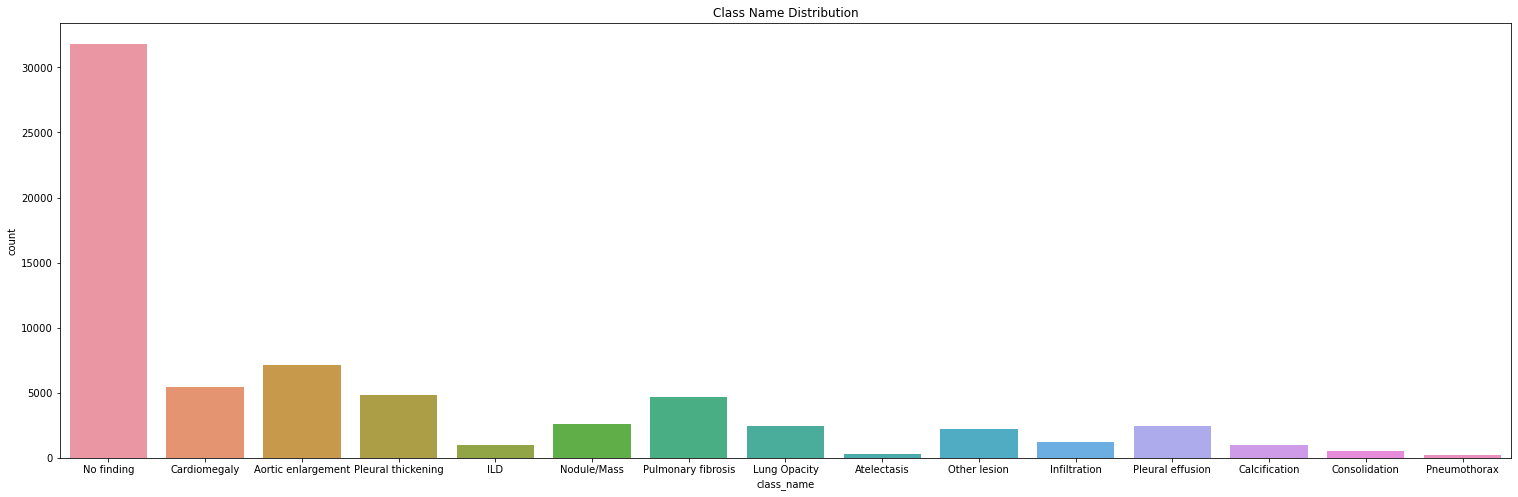

In [6]:
plt.figure(figsize=(26, 8))
sns.countplot(x="class_name", data=train_df)
plt.title("Class Name Distribution")
plt.show()

In [7]:
train_df['image_path'] = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/train/'+train_df.image_id+('.png' if dim!='original' else '.jpg')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,/kaggle/input/vinbigdata-512-image-dataset/vin...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,/kaggle/input/vinbigdata-512-image-dataset/vin...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,/kaggle/input/vinbigdata-512-image-dataset/vin...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,/kaggle/input/vinbigdata-512-image-dataset/vin...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,/kaggle/input/vinbigdata-512-image-dataset/vin...


In [8]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

> The average number of disease in patient

In [9]:
len(train_df)/train_df.image_id.nunique()

8.214838416021848

In [10]:
fold = 4
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
val_df = train_df[train_df['fold']==4]
val_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,fold
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072,/kaggle/input/vinbigdata-512-image-dataset/vin...,4
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353,/kaggle/input/vinbigdata-512-image-dataset/vin...,4
12,fb8e11c6b2886b2d41b379e0598669b9,Aortic enlargement,0,R10,1390.0,878.0,1616.0,1163.0,2304,2880,/kaggle/input/vinbigdata-512-image-dataset/vin...,4
13,0622cd29e4e0e4f198abf15614819ae8,Cardiomegaly,3,R10,1044.0,1579.0,2098.0,1971.0,2479,2674,/kaggle/input/vinbigdata-512-image-dataset/vin...,4
14,347180362348e522905047dde655b6d7,Pleural thickening,11,R9,1155.0,204.0,1414.0,268.0,2048,2500,/kaggle/input/vinbigdata-512-image-dataset/vin...,4


In [11]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(3515, 879)

In [12]:
os.makedirs('/kaggle/working/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/train', exist_ok = True)
os.makedirs('/kaggle/working/vinbigdata/images/val', exist_ok = True)
label_dir = '/kaggle/input/vinbigdata-yolo-labels-dataset/labels'
for file in train_files:
    shutil.copy(file, '/kaggle/working/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/train')
    
for file in val_files:
    shutil.copy(file, '/kaggle/working/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/kaggle/working/vinbigdata/labels/val')
    
val_dir = f'/kaggle/working/vinbigdata/images/val'

# YOLOv5 Set up

In [13]:
shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5') # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.6.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Inference

In [14]:
!python detect.py --weights $weights_dir\
--img 640\
--conf 0.15\
--iou 0.4\
--source $val_dir\
--save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/working/vinbigdata/images/val', update=False, view_img=False, weights=['/kaggle/input/vinbigdata-cxr-ad-yolov5-14-class-train/yolov5/runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/879 /kaggle/working/vinbigdata/images/val/00675cd546313f912cadd4ad54415d69.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 1 Infiltrations, 1 Lung Opacitys, 1 Pleural thickenings, Done. (0.057s)
image 2/879 /kaggle/working/vinbigdata/images/val/009d4c31ebf87e51c5c8c160a4bd8006.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 1 Lung Opacitys, 2 Pleural effusions, 1 Pulmonary fibrosiss, Done. (0.046s)
image 3/879 /kaggle/working/vinbigdata/images/val/00bcb82818ea83d6a86df241762cd7d0.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 1 Other lesions, 1 Pleural effusions, 2 Pleura

# Plot

100%|██████████| 16/16 [00:00<00:00, 104.36it/s]


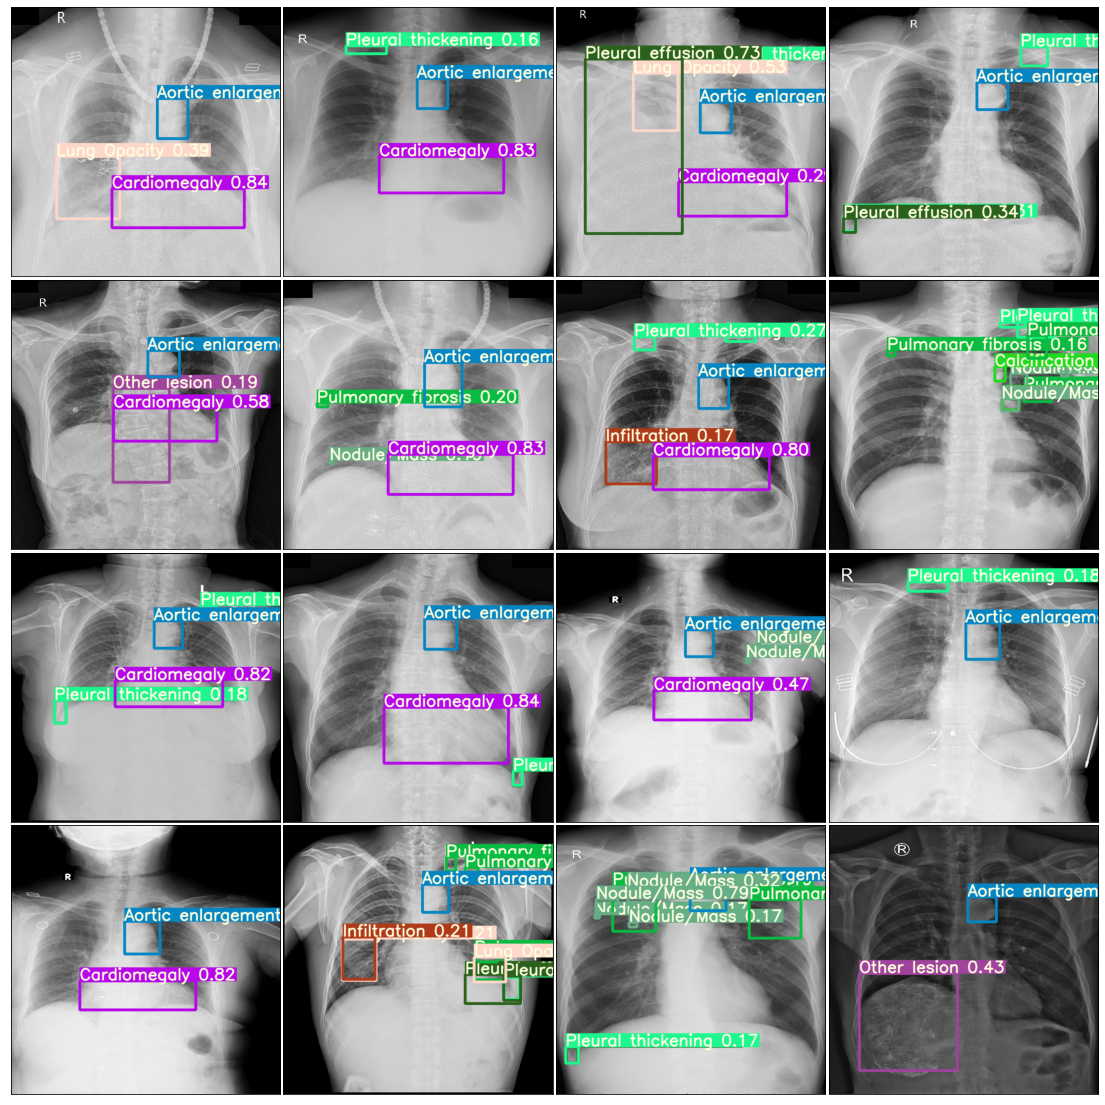

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*png')
for _ in range(1):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [16]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

# Data Distribution

In [17]:
image_ids = []
PredictionStrings = []
classes = []
scores = []
x_min = []
y_min = []
x_max = []
y_max = []


for file_path in glob('runs/detect/exp/labels/*txt'):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = val_df.loc[val_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1))#.astype(str))
    for i in range(len(bboxes)//6):
        image_ids.append(image_id)
        classes.append(int(bboxes[i*6]))
        scores.append(int(bboxes[i*6+1]))
        x_min.append(int(bboxes[i*6+2]))
        y_min.append(int(bboxes[i*6+3]))
        x_max.append(int(bboxes[i*6+4]))
        y_max.append(int(bboxes[i*6+5]))
#         bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
#     image_ids.append(image_id)
#     PredictionStrings.append(' '.join(bboxes))

In [18]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'classes':classes,
                        'scores':scores,
                        'x_min':x_min,
                        'y_min':y_min,
                        'x_max':x_max,
                        'y_max':y_max
                       })

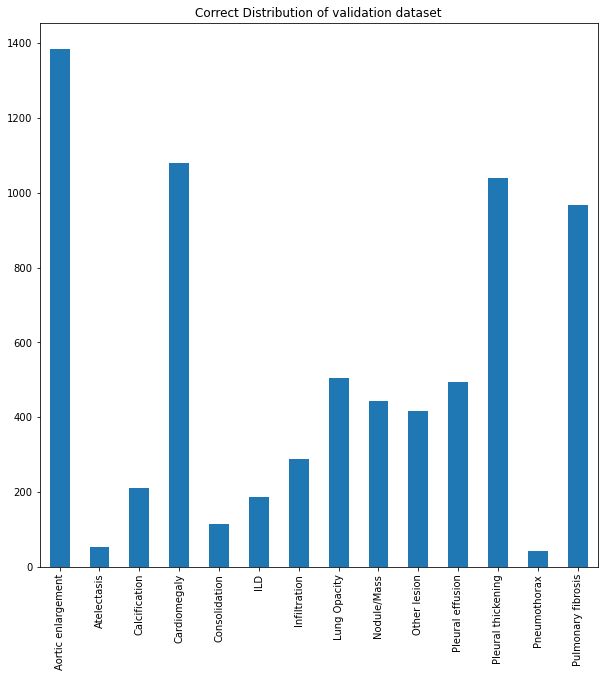

In [19]:
cids = val_df.class_name.value_counts().sort_index()

fig = plt.figure(figsize=(10,10))
ax = cids.plot.bar()
plt.title("Correct Distribution of validation dataset")
plt.xticks(rotation=90)
plt.show()

In [20]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))

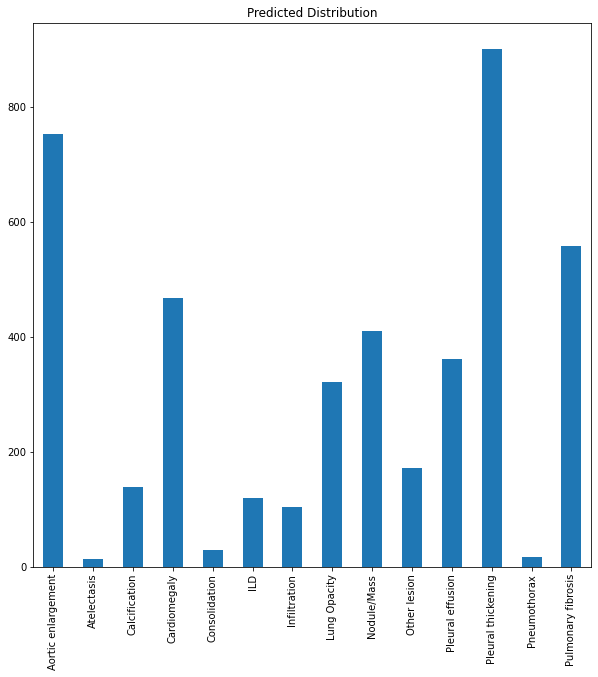

In [21]:
cids = pred_df.classes.value_counts().sort_index()#.to_frame()
cids.index = classes

fig = plt.figure(figsize=(10,10))
ax = cids.plot.bar()
plt.title("Predicted Distribution")
plt.xticks(rotation=90)
plt.show()

# Conclusion

* More than 70% of data is normal data

* The average number of disease in patient's X-ray image is about 8.2

* There is a difference between distirbution of prediction and ground truth. It will get worse if we include normal data

* Some diseases appear only in certain location in the image.